In [15]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.sparse as sp

## Parameters

In [16]:
horizon = 480 #5 days, 15-min intervals

In [17]:
# Create a model: Automatic Demand Response (ADR)
model = gp.Model("ADR") 

## Data Loading

### Electricity demand

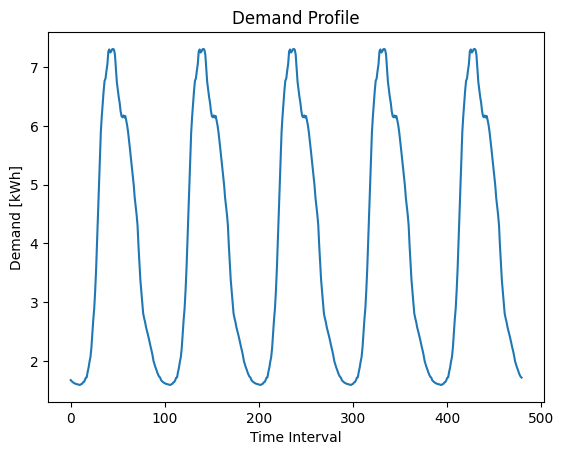

In [18]:
profile_demand = pd.read_csv('Demand_Data_15min.csv', sep=',', decimal='.')
facteur = 120000/1000000
real_Demand= profile_demand['Demand']*facteur
real_Demand = np.array(real_Demand)

#plot the Demand Column
plt.plot(real_Demand)
plt.title('Demand Profile')
plt.xlabel('Time Interval')
plt.ylabel('Demand [kWh]')
plt.show()


### Electricity price loading

/var/folders/18/5y9w3dms5fl1vf2k7gbs3r8m0000gn/T/ipykernel_38608/359558334.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  rng = pd.date_range(start, periods=horizon, freq='15T')


2024-04-07 00:00:00,19.94
2024-04-07 00:15:00,19.94
2024-04-07 00:30:00,19.94
2024-04-07 00:45:00,19.94
2024-04-07 01:00:00,19.94
2024-04-07 01:15:00,19.94
2024-04-07 01:30:00,19.94
2024-04-07 01:45:00,19.94
2024-04-07 02:00:00,19.94
2024-04-07 02:15:00,19.94
2024-04-07 02:30:00,19.94
2024-04-07 02:45:00,19.94
2024-04-07 03:00:00,19.94
2024-04-07 03:15:00,19.94
2024-04-07 03:30:00,19.94
2024-04-07 03:45:00,19.94
2024-04-07 04:00:00,19.94
2024-04-07 04:15:00,19.94
2024-04-07 04:30:00,19.94
2024-04-07 04:45:00,19.94
2024-04-07 05:00:00,19.94
2024-04-07 05:15:00,19.94
2024-04-07 05:30:00,19.94
2024-04-07 05:45:00,19.94
2024-04-07 06:00:00,31.73
2024-04-07 06:15:00,31.73
2024-04-07 06:30:00,31.73
2024-04-07 06:45:00,31.73
2024-04-07 07:00:00,31.73
2024-04-07 07:15:00,31.73
2024-04-07 07:30:00,31.73
2024-04-07 07:45:00,31.73
2024-04-07 08:00:00,31.73
2024-04-07 08:15:00,31.73
2024-04-07 08:30:00,31.73
2024-04-07 08:45:00,31.73
2024-04-07 09:00:00,31.73
2024-04-07 09:15:00,31.73
2024-04-07 0

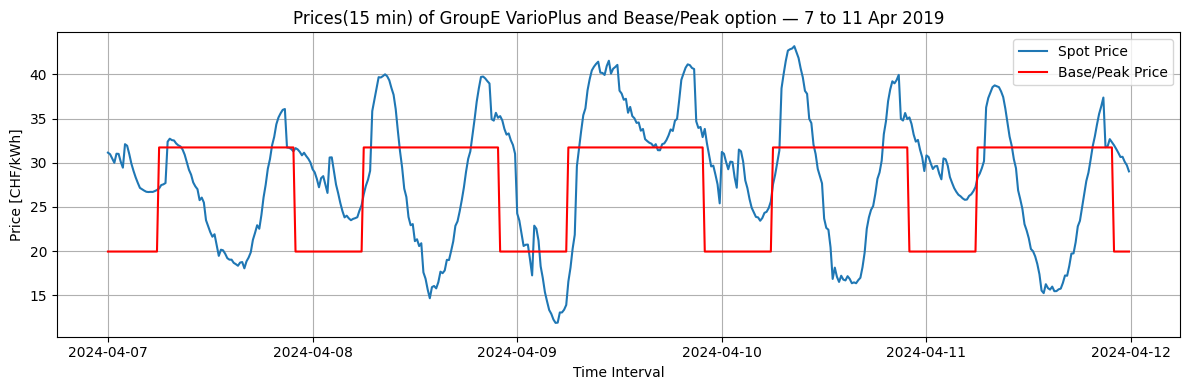

In [19]:
spot_prices = pd.read_csv('VarioPlus_2019-04-07_to_2019-04-11_15min.csv',parse_dates=['time'],index_col='time')
base_price = 19.94
peak_price = 31.73

#create an array called Base_Peak_price of the format 2019-04-07 00:00:00,5.901  where price from 6 to 22 is Peak Price and base otherwise 
start = spot_prices.index[0]
rng = pd.date_range(start, periods=horizon, freq='15T')
prices = [ peak_price if 6 <= ts.hour < 22 else base_price for ts in rng ]

Base_Peak_price_df = (pd.DataFrame({'price': prices}, index=rng) ) #dataframe with price for printing correctly
Base_Peak_price = list(zip(rng, prices))#tupple with time and price for the model to ensure smooth operation with edo's modifications
for t, p in Base_Peak_price:
    print(f"{t},{p}")

plt.figure(figsize=(12, 4))
plt.plot(spot_prices.index, spot_prices['price'],label='Spot Price')
plt.plot(Base_Peak_price_df.index, Base_Peak_price_df['price'],  label='Base/Peak Price', color='red')

plt.title('Prices(15 min) of GroupE VarioPlus and Bease/Peak option — 7 to 11 Apr 2019')
plt.xlabel('Time Interval')
plt.ylabel('Price [CHF/kWh]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

spot_prices = np.array(spot_prices['price'])

In [20]:
print(spot_prices.shape)

(480,)


### Temperature loading

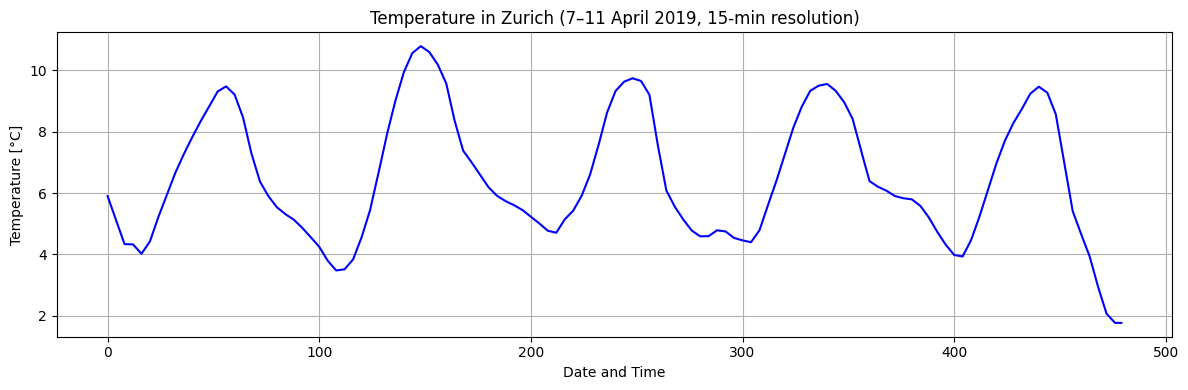

In [21]:
# i import and display Temperature_Data_Zurich_15min.csv
temperature_data = pd.read_csv('Temperature_Data_Zurich_15min.csv', parse_dates=['time'])
# Plot the temperature (°C) at 15-minute intervals
plt.figure(figsize=(12, 4))
plt.plot(temperature_data.index, temperature_data['temperature'], color='blue')
plt.title('Temperature in Zurich (7–11 April 2019, 15-min resolution)')
plt.xlabel('Date and Time')
plt.ylabel('Temperature [°C]')
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
temperature_data.head()

,time,temperature
0,2019-04-07 00:00:00,5.9010
1,2019-04-07 00:15:00,5.7065
2,2019-04-07 00:30:00,5.5120
3,2019-04-07 00:45:00,5.3175
4,2019-04-07 01:00:00,5.1230


### Solar irradiance

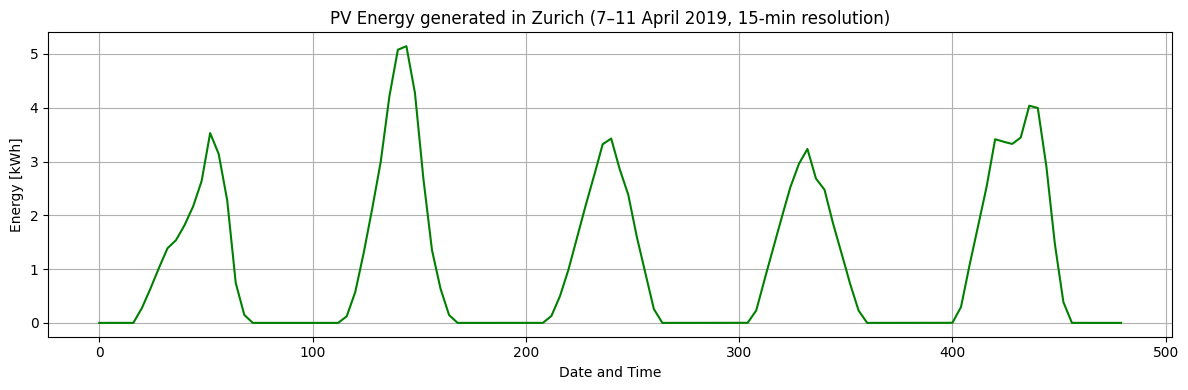

In [23]:
solar_energy = pd.read_csv('Solar_Energy_Zurich_15min.csv') #kWh/m²
PV_area = 200 # m²
PV_efficiency = 0.2 # 20% efficiency
PV_elec = solar_energy['Energy [kWh/m²]'] * PV_area * PV_efficiency # kWh
PV_elec = np.array(PV_elec)

# Plot the solar energy (kWh) at 15-minute intervals
plt.figure(figsize=(12, 4))
plt.plot(solar_energy.index, PV_elec, color='green')
plt.title('PV Energy generated in Zurich (7–11 April 2019, 15-min resolution)')
plt.xlabel('Date and Time')
plt.ylabel('Energy [kWh]')
plt.grid(True)
plt.tight_layout()
plt.show()  


## Modelling 

### EVs:

In [24]:
# --- PARAMETERS ---
n_evs        = 15          # number of EVs
P_rated      = 4.0         # kW, max charger power
E_req        = 6.0         # kWh, daily depleted energy of 6 kWh per EV
dt           = 0.25        # hours per time slot (15 min ⇒ 0.25 h)
T_day        = 96          # total 15-min slots per day
days         = 5           # number of days
start_idx    = 9 * 4       # 9:00 → slot 36
end_idx      = 18 * 4      # 18:00 → slot 72 (exclusive upper bound)
# index sets
evs = range(n_evs) 
slots = range(T_day)
days_ = range(days)

# continuous variable p[e,t] ∈ [0, P_rated] = charging power of EV e in slot t (kW)
p = model.addVars(evs, days, slots, #create set of decision variables, indexed by EVs, time slots and day
            #each variable p[e, t] corresponds to the charging power of EV e during time slot t in kW
            vtype=GRB.CONTINUOUS,
            lb=0.0, # lower bound of the variable
            ub=P_rated, # upper bound of the variable, P_rated is the maximum charging power
            name="p") #base name of the variable

# 1) Energy requirement: each EV must accumulate E_req kWh over the allowed window
for e in evs:
    for d in days_:
        model.addConstr(
            gp.quicksum(p[e,d,t] * dt for t in range(start_idx, end_idx)) == E_req,
            name=f"energy_e{e}_d{d}"
        )

# 2) Enforce zero charging outside [9:00,18:00), each day.
for e in evs:
    for d in days_:
        # before 9:00
        for t in range(0, start_idx):
            model.addConstr(p[e,d,t] == 0,
                        name=f"zero_before_e{e}_d{d}_t{t}")
        # after 18:00
        for t in range(end_idx, T_day):
            model.addConstr(p[e,d,t] == 0,
                        name=f"zero_after_e{e}_d{d}_t{t}")

# (the ub=P_rated on p already enforces p[e,t] ≤ P_rated for all t)

# 3) Total cost of charging: 
total_cost_EV = gp.LinExpr() #important to define the total cost as a gurobi linear expression!

for e in evs:
    for d in days_:
        for t in slots:
            index = d * T_day + t  # flat index into spot_price
            price = spot_prices[index]  # CHF per kWh
            total_cost_EV += p[e, d, t] * price * dt

print("Total cost of EV:")
print(total_cost_EV)

Total cost of EV:
7.785 <gurobi.Var *Awaiting Model Update*> + 7.74 <gurobi.Var *Awaiting Model Update*> + 7.62 <gurobi.Var *Awaiting Model Update*> + 7.4975 <gurobi.Var *Awaiting Model Update*> + 7.755 <gurobi.Var *Awaiting Model Update*> + 7.75 <gurobi.Var *Awaiting Model Update*> + 7.5275 <gurobi.Var *Awaiting Model Update*> + 7.36 <gurobi.Var *Awaiting Model Update*> + 8.025 <gurobi.Var *Awaiting Model Update*> + 7.98 <gurobi.Var *Awaiting Model Update*> + 7.745 <gurobi.Var *Awaiting Model Update*> + 7.4725 <gurobi.Var *Awaiting Model Update*> + 7.2675 <gurobi.Var *Awaiting Model Update*> + 7.085 <gurobi.Var *Awaiting Model Update*> + 6.93 <gurobi.Var *Awaiting Model Update*> + 6.7875 <gurobi.Var *Awaiting Model Update*> + 6.7475 <gurobi.Var *Awaiting Model Update*> + 6.71 <gurobi.Var *Awaiting Model Update*> + 6.6775 <gurobi.Var *Awaiting Model Update*> + 6.67 <gurobi.Var *Awaiting Model Update*> + 6.675 <gurobi.Var *Awaiting Model Update*> + 6.6725 <gurobi.Var *Awaiting Model Upd

### Additive Manufacturing (AM) Machines

In [25]:
# Parameters
n_AMM = 5 # number of AM machines
AMM = range(n_AMM) # index set for AM machines
power_AMM = 2.76  # Power consumption of each printer in kW

# Full cycle of a printer corresponds to 4 hours of operation (or 16 slots of 15 minutes)
D = 16

# Decision variable, x[m,t] = 1 if machine m starts a job at time t
x = model.addVars(n_AMM,horizon,vtype=GRB.BINARY,name='start')

# Prevent overlapping jobs on the same machine: Ensures machine m can't start two jobs too close together
for m in AMM:
    for t1 in range(horizon - D + 1):
        for t2 in range(t1 + 1, min(t1 + D, horizon - D + 1)):
            model.addConstr(x[m, t1] + x[m, t2] <= 1,
                            name=f"no_overlap_m{m}_t{t1}_t{t2}")

# Last feasible time to start

# Every week, 100 pieces must be produced (20 per day)
model.addConstr(
    gp.quicksum(x[m, t] for m in AMM for t in range(horizon - D + 1)) >= 100,
    name="min_production"
)

# total cost of the AM machines
cost_AMM = gp.quicksum(x[m, t] * spot_prices[t] * power_AMM * dt for m in AMM for t in range(horizon))

### Heating demand

In [ ]:
# --- PARAMETERS FOR THERMAL MODEL ---
COP_h = 2.5               # Heating COP
COP_c = 2.5               # Cooling COP
inertia = 0.98            # Inertia factor ϵ
A_th = 2.0                # Thermal conductivity [kW/°C]
T_desired = 19.0          # Setpoint temperature [°C]
dead_band = 2.0           # ± dead-band [°C]
T_lower = T_desired - dead_band  # Lower comfort limit (17°C)
T_upper = T_desired + dead_band  # Upper comfort limit (21°C)

# Initial indoor temperature (set here at the lower bound, can be modified)
T_0 = T_lower

# Use the outside temperature from your temperature_data; ensure the ordering/matching with time steps.
T_out = temperature_data['temperature'].values

N = horizon               # Total number of intervals 

# Define working hours mask (09:00–18:00); T_set is used only to indicate working hours
mask_work = (temperature_data['time'].dt.hour >= 9) & (temperature_data['time'].dt.hour < 18)
T_set = np.full(horizon, np.nan)
T_set[mask_work.values] = T_desired

# Compute effective heating and cooling coefficients:
alpha_h = (1 - inertia) * (COP_h / A_th)   # Effect of additional heating
alpha_c = (1 - inertia) * (COP_c / A_th)   # Effect of additional cooling

# Decision variables:
# Define p_h for heating power and p_c for cooling power.
# Here, the space heater is sized at 40 kW; you might set a similar bound for cooling.
p_h = model.addVars(horizon-1, lb=0.0, ub=40.0, name="p_heat")
p_c = model.addVars(horizon-1, lb=0.0, ub=40.0, name="p_cool")

# Indoor temperature state variables:
T_in = model.addVars(horizon, lb=-GRB.INFINITY, name="T_in")
model.addConstr(T_in[0] == T_0, name="init_temp")

# Thermal dynamics constraint:
# T_in[k+1] = inertia * T_in[k] + (1 - inertia) * T_out[k] + (alpha_h * p_h[k]) - (alpha_c * p_c[k])
for k in range(N-1):
    model.addConstr(
        T_in[k+1] == inertia * T_in[k] + (1 - inertia) * T_out[k] + alpha_h * p_h[k] - alpha_c * p_c[k],
        name=f"dyn_{k}"
    )

# Comfort constraints (only enforced during working hours):
# Ensure that T_in stays within [T_lower, T_upper] (i.e. within ±2°C of 19°C)
for k in range(N):
    if not np.isnan(T_set[k]):
        model.addConstr(T_in[k] >= T_lower, name=f"min_comfort_{k}")
        model.addConstr(T_in[k] <= T_upper, name=f"max_comfort_{k}")

# Energy consumption of the heating and cooling systems using spot prices
cost_HC = gp.quicksum((p_h[k] + p_c[k]) * dt * spot_prices[k] for k in range(horizon-1))

### Objective function

In [27]:

# Cost function
model.setObjective(cost_AMM)

# Solve the model, i.e. minimize the cost
model.write('out.lp')
model.optimize(cost_AMM + total_cost_EV)


GurobiError: Callback argument must be a callable